In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, jit, jacobian, value_and_grad
from jax.flatten_util import ravel_pytree
from helper_functions import *
import optax
from scipy.linalg import block_diag

In [2]:
def random_params(di, Nh, do, key):
    w_key, c_key = random.split(key)
    C = 1/jnp.sqrt((di+1)) * random.normal(c_key, (Nh, di + 1)) 
    W = 1/jnp.sqrt(Nh) * random.normal(w_key, (do, Nh)) 
    return {"C": C, "W": W}

def shallow_nn(x, params):
    x = jnp.vstack((x, jnp.ones((1, x.shape[1]))))           # Add 1 as the bias input
    h = jnp.tanh(jnp.matmul(params["C"], x)) 
    y = jnp.matmul(params["W"], h)  
    return y                                          

def output_from_flat_params(flat_params, unravel_fn, x):
    params = unravel_fn(flat_params)
    return shallow_nn(x, params)        # shape: (do, no_of_samples)

def compute_GGN(current_flat_params, unravel_fn, x):
    no_of_samples = x.shape[1]
    J = jacobian(output_from_flat_params)(current_flat_params, unravel_fn, x)       # shape: (do, no_of_samples, P)
    J = J.reshape(-1, current_flat_params.shape[0])                                 # shape: (do * no_of_samples, P)
    GGN = 2/no_of_samples * (J.T @ J)
    return GGN

def mse_loss(flat_params, unravel_fn, x, y_true):
    y_pred = output_from_flat_params(flat_params, unravel_fn, x) 
    return jnp.mean(jnp.sum((y_pred - y_true) ** 2, axis=0))  # sum over outputs, mean over samples

In [3]:
no_of_samples = 600      # no of training samples
di = 5                   # input dimension
do = 3
Nh = 10

P = Nh * (di + 1) + do * Nh
print('P:', P)

layers = [(Nh, di+1), (do, Nh)]   

## Generate covariance matrix from which we will sample inputs ##
alpha = 1.5
eigenvalues = np.array([1 / (i + 1)**alpha for i in range(di)])  # power law
Q, _ = np.linalg.qr(np.random.randn(di, di))
sigma = Q @ np.diag(eigenvalues) @ Q.T

# Sample input data
samples_key = random.PRNGKey(13)
z = random.normal(samples_key, (di, no_of_samples))         # input vector (di x no_of_samples)
x = np.linalg.cholesky(sigma) @ z

# make ground-truth / teacher params
teacher_key = random.PRNGKey(2)
teacher_params = random_params(di, Nh, do, teacher_key)
flat_teacher_params, teacher_unravel_fn = ravel_pytree(teacher_params)

y = shallow_nn(x, teacher_params)  # shape: (do, no_of_samples)
print('y.shape:', y.shape)
print('x.shape:', x.shape)


P: 90
y.shape: (3, 600)
x.shape: (5, 600)


In [4]:
# learn the parameters
student_key = random.PRNGKey(3)
student_params = random_params(di, Nh, do, student_key)
flat_student_params, student_unravel_fn = ravel_pytree(student_params)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(flat_student_params)

# --- Loss + gradient function ---
@jit
def step(flat_params, opt_state, x, y):
    loss_val, grads = value_and_grad(mse_loss)(flat_params, student_unravel_fn, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(flat_params, updates)
    return new_params, opt_state, loss_val


stop_points = [0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 29999]
stop_points2 = [0, 7000, 28000]
params_at_points = []

# --- Training loop ---
num_steps = 30000
losses = []

for step_idx in range(num_steps):
    flat_student_params, opt_state, loss = step(flat_student_params, opt_state, x, y)
    losses.append(loss)
    if step_idx % 100 == 0:
        print(f"Step {step_idx}, Loss: {loss}")
    if step_idx in stop_points:
        params_at_points.append(flat_student_params)

final_params = flat_student_params

Step 0, Loss: 1.6723438501358032
Step 100, Loss: 0.563076376914978
Step 200, Loss: 0.2146105319261551
Step 300, Loss: 0.10348396748304367
Step 400, Loss: 0.06480094790458679
Step 500, Loss: 0.047426801174879074
Step 600, Loss: 0.037465501576662064
Step 700, Loss: 0.031191011890769005
Step 800, Loss: 0.027188507840037346
Step 900, Loss: 0.02452029660344124
Step 1000, Loss: 0.022550096735358238
Step 1100, Loss: 0.020938465371727943
Step 1200, Loss: 0.01953825168311596
Step 1300, Loss: 0.018287846818566322
Step 1400, Loss: 0.01715661957859993
Step 1500, Loss: 0.016125692054629326
Step 1600, Loss: 0.01518195029348135
Step 1700, Loss: 0.014315764419734478
Step 1800, Loss: 0.013519682921469212
Step 1900, Loss: 0.012787457555532455
Step 2000, Loss: 0.012113356962800026
Step 2100, Loss: 0.011491673067212105
Step 2200, Loss: 0.010916449129581451
Step 2300, Loss: 0.01038138847798109
Step 2400, Loss: 0.009879927150905132
Step 2500, Loss: 0.009405449964106083
Step 2600, Loss: 0.008951559662818909


In [5]:
GGN_teacher = compute_GGN(flat_teacher_params, teacher_unravel_fn, x)

heatmaps = []
heatmaps.append(GGN_teacher)
singular_values = []
_, s, _ = jnp.linalg.svd(GGN_teacher)
singular_values.append(s)

differences = []


for i, stop_point in enumerate(stop_points):
    params = student_unravel_fn(params_at_points[i])
    GGN = compute_GGN(params_at_points[i], student_unravel_fn, x)
    differences.append(jnp.linalg.norm(GGN - GGN_teacher, ord='fro')/jnp.linalg.norm(GGN_teacher, ord='fro'))
    if stop_point in stop_points2:
        heatmaps.append(GGN)
        _, s, _ = jnp.linalg.svd(GGN)
        singular_values.append(s)
    

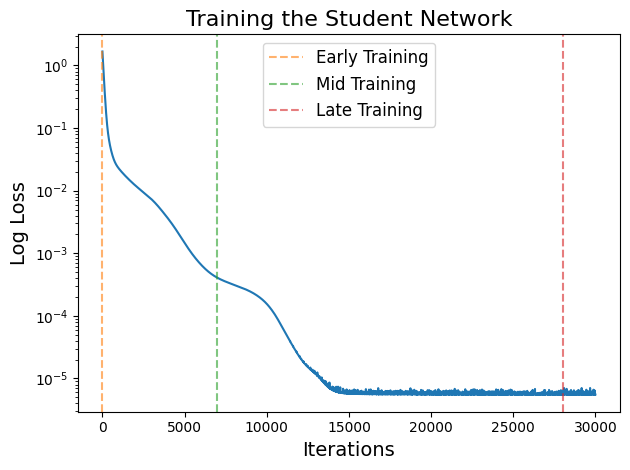

In [6]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.title('Training the Student Network', fontsize=16)

labels_points = ['Early Training', 'Mid Training', 'Late Training']
colours = ['tab:orange', 'tab:green', 'tab:red']
for i, stop_point in enumerate(stop_points2):
    plt.axvline(x=stop_point, color=colours[i], linestyle='--', alpha=0.6, label=labels_points[i])

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('training_the_student.png', dpi=300)
plt.show()

In [7]:
# conv 2d


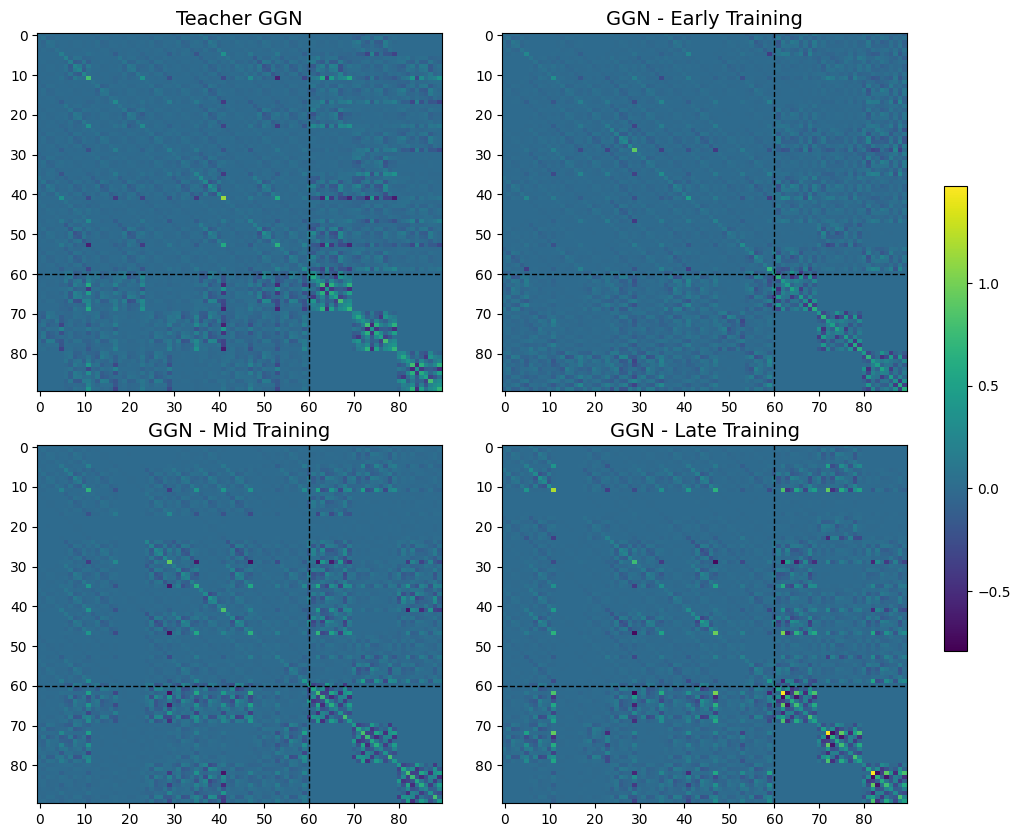

In [8]:
vmin = min(h.min() for h in heatmaps)
vmax = max(h.max() for h in heatmaps)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.15)  # Increase spacing

axes = axes.flatten()

ims = []
titles = ["Teacher GGN", "GGN - Early Training", "GGN - Mid Training", "GGN - Late Training"]
for i, (ax, h) in enumerate(zip(axes, heatmaps)):
    im = ax.imshow(h, vmin=vmin, vmax=vmax, cmap='viridis', aspect='auto')
    ax.axhline(y=(di+1)*Nh, color='k', linewidth=1, linestyle='--')
    ax.axvline(x=(di+1)*Nh, color='k', linewidth=1, linestyle='--')
    ax.set_title(titles[i], fontsize=14)

    ims.append(im)

fig.colorbar(ims[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
plt.savefig('heatmaps_at_different_points.png', dpi=300)
plt.show()


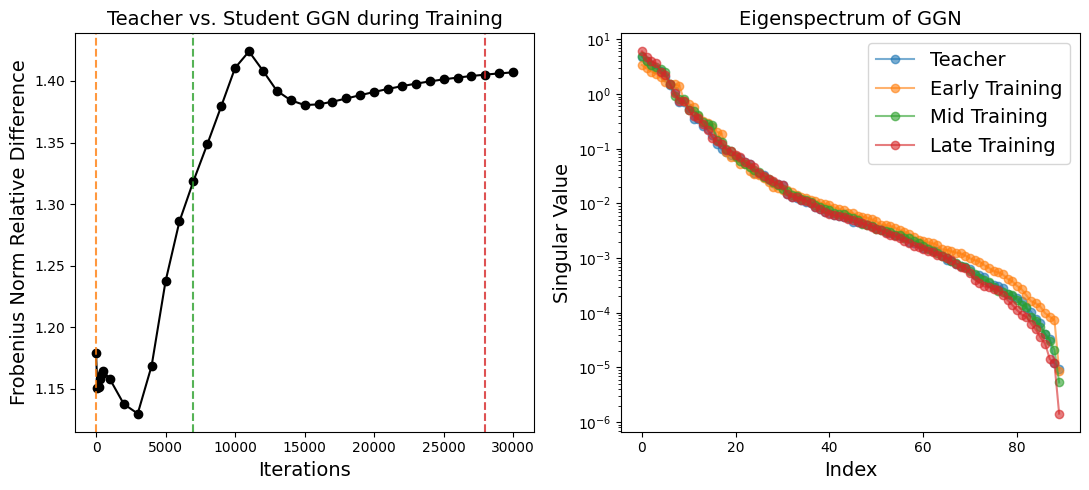

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].plot(stop_points, differences,'-o', color='k')
axes[0].set_title('Teacher vs. Student GGN during Training', fontsize=14)
axes[0].set_xlabel('Iterations', fontsize=14)
axes[0].set_ylabel('Frobenius Norm Relative Difference', fontsize=14)
labels_points = ['Early Training', 'Mid Training', 'Late Training']
colours = ['tab:orange', 'tab:green', 'tab:red']
for i, stop_point in enumerate(stop_points2):
    axes[0].axvline(x=stop_point, color=colours[i], linestyle='--', alpha=0.8, label=labels_points[i])

labels_points = ['Early Training', 'Mid Training', 'Late Training']
# Plot heatmaps
for i in range(len(singular_values)):
    label = f"{labels_points[i-1]}"
    if i == 0:
        label = "Teacher"
    axes[1].plot(singular_values[i], '-o', label=label, alpha=0.6)
axes[1].set_title('Eigenspectrum of GGN', fontsize=14)
axes[1].set_xlabel('Index', fontsize=14)
axes[1].set_ylabel('Singular Value', fontsize=14)
axes[1].set_yscale('log')
axes[1].legend(fontsize=14)
plt.tight_layout()
plt.savefig('differences_and_singular_values.png', dpi=300)
plt.show()


standard distance between PSD matrices 

In [10]:
final_GGN = compute_GGN(final_params, student_unravel_fn, x)
print('Final GGN shape:', final_GGN.shape)

Final GGN shape: (90, 90)


In [11]:
learned_G, losses, losses1, losses2 = learn_G_multiple_layers(layers, final_GGN, iters=25000, K=10, learning_rate=1e-4)
block1 = KP_sum(learned_G[0])
block2 = KP_sum(learned_G[1])
learned_G_matrix = block_diag(block1, block2)

Iteration: 0, Loss: 255.79495239257812 for layer [False]
Iteration: 100, Loss: 45.64263153076172 for layer [ True]
Iteration: 200, Loss: 355.5871887207031 for layer [False]
Iteration: 300, Loss: 253.25657653808594 for layer [False]
Iteration: 400, Loss: 40.07036590576172 for layer [ True]
Iteration: 500, Loss: 36.2730827331543 for layer [ True]
Iteration: 600, Loss: 244.57537841796875 for layer [False]
Iteration: 700, Loss: 40.86543273925781 for layer [ True]
Iteration: 800, Loss: 177.23509216308594 for layer [False]
Iteration: 900, Loss: 164.94430541992188 for layer [False]
Iteration: 1000, Loss: 35.78392028808594 for layer [ True]
Iteration: 1100, Loss: 122.6728515625 for layer [False]
Iteration: 1200, Loss: 148.0323028564453 for layer [False]
Iteration: 1300, Loss: 113.92101287841797 for layer [False]
Iteration: 1400, Loss: 16.232133865356445 for layer [ True]
Iteration: 1500, Loss: 30.356536865234375 for layer [ True]
Iteration: 1600, Loss: 21.900087356567383 for layer [ True]
Iter

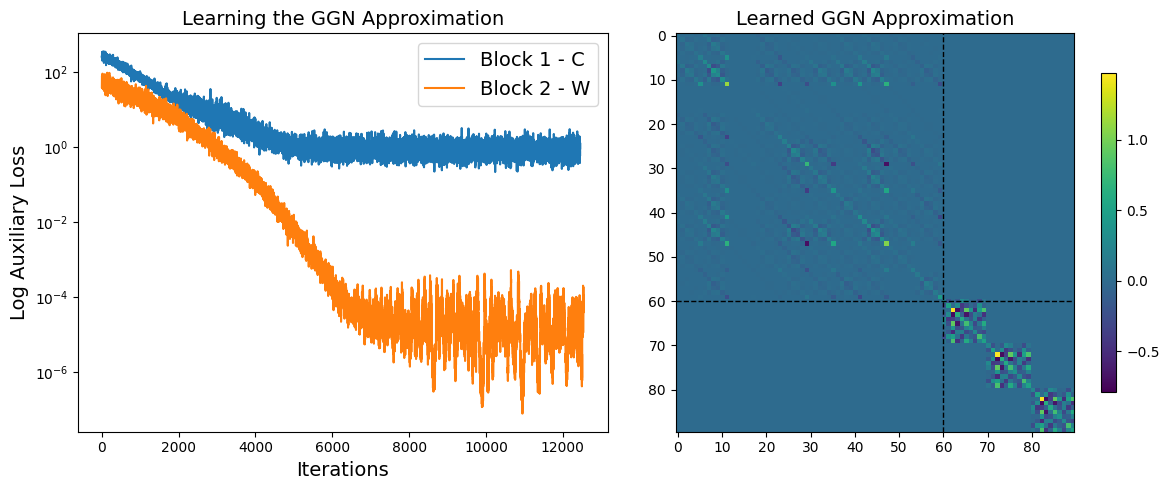

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(losses1, label='Block 1 - C')
axs[0].plot(losses2, label='Block 2 - W')
axs[0].set_yscale('log')
axs[0].set_xlabel('Iterations', fontsize=14)
axs[0].set_ylabel('Log Auxiliary Loss', fontsize=14)
axs[0].legend(fontsize=14)
axs[0].set_title('Learning the GGN Approximation', fontsize=14)
axs[1].imshow(learned_G_matrix, cmap='viridis')
axs[1].set_title('Learned GGN Approximation', fontsize=14)
axs[1].axhline(y=(di+1)*Nh, color='k', linewidth=1, linestyle='--')
axs[1].axvline(x=(di+1)*Nh, color='k', linewidth=1, linestyle='--')
im = axs[1].imshow(learned_G_matrix, vmin=vmin, vmax=vmax, cmap='viridis')

plt.colorbar(im, ax=axs[1], shrink=0.8)
plt.tight_layout()
plt.savefig('student_learned_GGN_approximation.png', dpi=300)
plt.show()